In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

In [ ]:
def load_image(image_path,max_size=400,shape=None):
  image = Image.open(image_path).convert('RGB')

  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)
  if shape is not None:
    size = shape
  
  in_transforms = transforms.Compose([
                                      transforms.Resize((size,int(1.5 * size))),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
  image = in_transforms(image)[:3,:,:].unsqueeze(0)

  return image

In [ ]:
style = load_image('/content/drive/My Drive/Style Transfer/Starry-Night-canvas-Vincent-van-Gogh-New-1889.jpg')

In [ ]:
def im_convert(tensor):
  image = tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array(
    (0.485, 0.456, 0.406))
  image = image.clip(0, 1)
  
  return image

In [ ]:
def get_features(image,model,layers=None):
  if layers is None:
    layers = {'0': 'conv1_1','5': 'conv2_1',
              '10': 'conv3_1',
              '19': 'conv4_1',
              '21': 'conv4_2',  ## content layer
              '28': 'conv5_1'}
  features = {}
  x = image
  
  for name,layer in enumerate(model.features):
    x = layer(x)
    if str(name) in layers:
      features[layers[str(name)]] = x
  
  return features

In [ ]:
def gram_matrix(tensor):
  _,n_filters, h, w = tensor.size()
  tensor = tensor.view(n_filters, h*w)
  gram = torch.mm(tensor,tensor.t())

  return gram

In [ ]:
vgg = models.vgg19()
vgg.load_state_dict(torch.load('/content/drive/My Drive/Style Transfer/vgg19-dcbb9e9d.pth'))

for param in vgg.parameters():
  param.requires_grad_(False)

In [ ]:
for i,layer in enumerate(vgg.features):
  if isinstance(layer,torch.nn.MaxPool2d):
    vgg.features[i] = torch.nn.AvgPool2d(kernel_size=2,stride=2,padding=0)
    

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device).eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace=True)
    (18): AvgPool

In [ ]:
content = load_image('/content/drive/My Drive/Burj-Khalifa-world-Sheikh-Khalifah-ibn-Zayid-2010.jpg').to(device)
style = style.to(device)

content_features = get_features(content,vgg)
style_features = get_features(style, vgg)

In [ ]:
style_grams = {
    layer : gram_matrix(style_features[layer]) for layer in style_features
}

In [ ]:
target = torch.rand_like(content).requires_grad_(True).to(device)

In [ ]:
style_weights = {'conv1_1': 0.75,
                 'conv2_1': 0.5,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

In [ ]:
content_weight = 1e4
style_weight = 1e2

In [ ]:
optimizer = optim.Adam([target], lr=0.01)

In [ ]:
for i in range(1000):
  optimizer.zero_grad()
  target_features = get_features(target, vgg)
  
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
  
  style_loss = 0
  for layer in style_weights:
    target_feature = target_features[layer] 
    target_gram = gram_matrix(target_feature)
    _,d,h,w = target_feature.shape
    style_gram = style_grams[layer]

    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)

    style_loss += layer_style_loss/(d*h*w)

  total_loss = content_weight*content_loss + style_weight*style_loss

  total_loss.backward(retain_graph=True)

  optimizer.step()

  if i % 10 == 0:
    total_loss_rounded = round(total_loss.item(),2)

    content_fraction = round(content_weight*content_loss.item()/total_loss.item(),2)

    style_fraction = round(style_weight*style_loss.item()/total_loss.item(),2)

    print('Iteration {}, Total loss: {} - (content: {}, style {})'.format(
      i,total_loss_rounded, content_fraction, style_fraction))



Iteration 0, Total loss: 161.06 - (content: 0.63, style 0.37)
Iteration 10, Total loss: 160.93 - (content: 0.63, style 0.37)
Iteration 20, Total loss: 160.78 - (content: 0.63, style 0.37)
Iteration 30, Total loss: 160.65 - (content: 0.63, style 0.37)
Iteration 40, Total loss: 160.5 - (content: 0.63, style 0.37)
Iteration 50, Total loss: 160.35 - (content: 0.63, style 0.37)
Iteration 60, Total loss: 160.23 - (content: 0.63, style 0.37)
Iteration 70, Total loss: 160.08 - (content: 0.63, style 0.37)
Iteration 80, Total loss: 159.95 - (content: 0.63, style 0.37)
Iteration 90, Total loss: 159.81 - (content: 0.63, style 0.37)
Iteration 100, Total loss: 159.68 - (content: 0.63, style 0.37)
Iteration 110, Total loss: 159.56 - (content: 0.63, style 0.37)
Iteration 120, Total loss: 159.41 - (content: 0.63, style 0.37)
Iteration 130, Total loss: 159.31 - (content: 0.63, style 0.37)
Iteration 140, Total loss: 159.17 - (content: 0.63, style 0.37)
Iteration 150, Total loss: 159.05 - (content: 0.63, 

In [ ]:
final_img = im_convert(target)

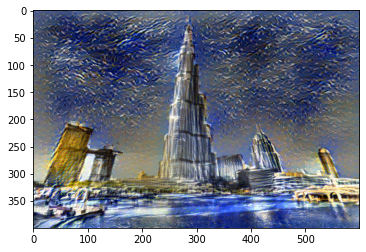

In [ ]:
plt.imshow(final_img)